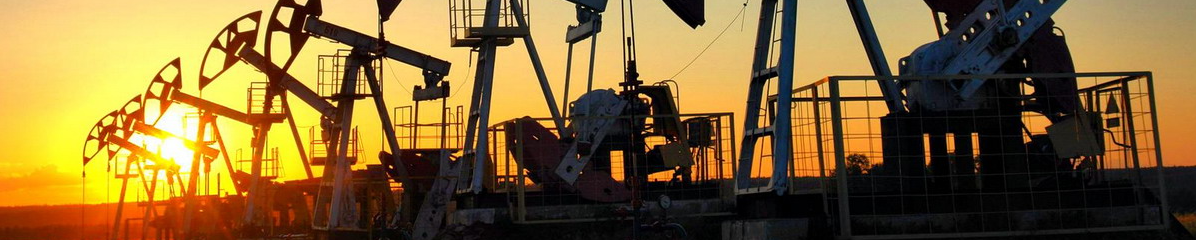

# Выбор локации для скважин

**Цель работы**

Построить модель машинного обучения, которая поможет определить регион, где добыча нефти принесёт наибольшую прибыль.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 скважин, где их характеристики и объём запасов нефти.\
В датасете не уточняется какие именно характеристики, но это может быть: геология местности, давление нефти в скважине, её хим.состав, плотность.

**Ход работы**
1) изучить 3 датасета, выявить аномалии;
2) подготовить данные (разбить на выборки обучающие и валидационные, масштабировать);
3) обучить модели (подходит только линейная регрессия, остальные — недостаточно предсказуемые), сделать предсказания для валидационных выборок;
4) техникой Bootstrap для каждого региона создать массив/распределение из прибылей; при разведке региона исследуют (рандомно) 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки; объёмы скважин суммируются целевые (из исходных датасетов, а не предсказания); бюджет на разведку 500-та скважин и разработку 200-т — 10 млрд рублей; доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
5) определить среднюю прибыль (из Butstrap распределения) и риск убытков;
6) после оценки рисков оставить лишь те регионы, в которых вероятность убытков меньше 2.5%; среди них берётся регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
try:
    data_0 = pd.read_csv('../../08 ML в бизнесе/project/geo_data_0.csv')
    data_1 = pd.read_csv('../../08 ML в бизнесе/project/geo_data_1.csv')
    data_2 = pd.read_csv('../../08 ML в бизнесе/project/geo_data_2.csv')
except:
    try:
        data_0 = pd.read_csv('/datasets/geo_data_0.csv')
        data_1 = pd.read_csv('/datasets/geo_data_1.csv')
        data_2 = pd.read_csv('/datasets/geo_data_2.csv')
    except:
        data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
        data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
        data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
# объединим все 3 df в список пар-кортежей (название df, df)
data = [('data_0',data_0), ('data_1',data_1), ('data_2',data_2)]

In [4]:
# общая информация по трём df
for name, df in data:
    print('\n', name,'   👇')
    df.info()


 data_0    👇
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

 data_1    👇
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

 data_2    👇
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns 

In [5]:
data_0.head(3) # первые строки одного из df

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


In [6]:
# описание количественных призначков у всех трёх df
data_0.describe().join(data_1.describe(), rsuffix='_1').\
                  join(data_2.describe(), lsuffix='_0', rsuffix='_2').round(2)

,f0_0,f1_0,f2_0,product_0,f0_1,f1_1,f2_1,product_1,f0_2,f1_2,f2_2,product_2
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50,1.14,-4.80,2.49,68.83,0.00,-0.00,2.50,95.00
std,0.87,0.50,3.25,44.29,8.97,5.12,1.70,45.94,1.73,1.73,3.47,44.75
min,-1.41,-0.85,-12.09,0.00,-31.61,-26.36,-0.02,0.00,-8.76,-7.08,-11.97,0.00
25%,-0.07,-0.20,0.29,56.50,-6.30,-8.27,1.00,26.95,-1.16,-1.17,0.13,59.45
50%,0.50,0.25,2.52,91.85,1.15,-4.81,2.01,57.09,0.01,-0.01,2.48,94.93
75%,1.07,0.70,4.72,128.56,8.62,-1.33,4.00,107.81,1.16,1.16,4.86,130.60
max,2.36,1.34,16.00,185.36,29.42,18.73,5.02,137.95,7.24,7.84,16.74,190.03


In [7]:
# суммарный объём нефти в каждом датасете
for name, df in data:
    print(f"{name}  {df['product'].sum():.0f}")

data_0  9250000
data_1  6882500
data_2  9500000


Медианы и суммы запасов в 0-ом и 2-ом регионе значительно выше, чем в 1-ом.\
Казалось бы можно сделать вывод о бесперспективности разработки новых скважин в 1-ом регионе.

In [8]:
# число дубликатов в df
for name, df in data:
    print(f'в {name} задублированных объектов {df.duplicated().sum()}')

в data_0 задублированных объектов 0
в data_1 задублированных объектов 0
в data_2 задублированных объектов 0


In [9]:
# число задублированных id
for name, df in data:
    print(f'в {name} задублированных id {df["id"].duplicated().sum()}')

в data_0 задублированных id 10
в data_1 задублированных id 4
в data_2 задублированных id 4


In [10]:
# объекты с задублированными id
for name, df in data:
    print(name,'   👇')
    display(df[df['id'].isin(df['id'][df['id'].duplicated()].values)].sort_values(by='id'))

data_0    👇


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


data_1    👇


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


data_2    👇


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Причина дублирования не выявлена. Объекты с одним id разные. Отметим данный факт, но ничего с дублями делать не будем, так как в дальнейшем нам не потребуется точная идентификация объекта.

In [11]:
# количество задублированных объектов без учёта id
for name, df in data:
    print(f'в {name} без учёта id задублированных объектов {df.drop("id",axis=1).duplicated().sum()}')

в data_0 без учёта id задублированных объектов 0
в data_1 без учёта id задублированных объектов 0
в data_2 без учёта id задублированных объектов 0


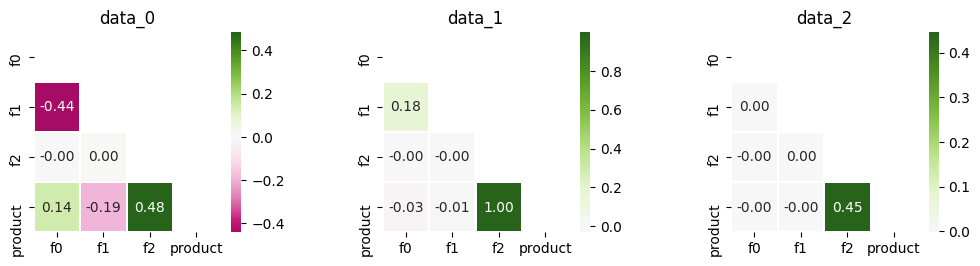

In [12]:
# корреляция между признаками
f, ax = plt.subplots(1,3, figsize=(12,2.6), gridspec_kw={'wspace':0.5})

for n, (name, df) in enumerate(data):
    ax[n].set_title(name)
    matrix=np.tri(len(df.corr())).T
    sns.heatmap(df.corr(), annot=True, mask=matrix, fmt='.2f', cmap='PiYG', linewidth=1, center=0, ax=ax[n])

В data_1 видим предельно высокую корреляцию между признаком f2 и объёмом запасов в скважине. Похоже на утечку целевого признака. Либо это особенность региона.\
По региону "1" качество предсказаний модели будет очень высоким.\
Признак оставляем. Мы не можем однозначно убедиться в утечке. В реальном производстве надо было бы пообщаться с коллегами и выяснить причину такой высокой связи.

In [13]:
data_1[['f2','product']]

,f2,product
0,-0.005876,3.179103
1,0.999183,26.953261
2,5.001160,134.766305
3,4.999415,137.945408
4,5.004363,134.766305
...,...,...
99995,1.998296,53.906522
99996,5.005581,137.945408
99997,4.998651,137.945408
99998,1.000146,30.132364


## Обучение и проверка модели

In [14]:
# разбиваем исходные df на признаки и целевой признак; формируем список из 3-х df'оф с признаками и список из 3-х Series с ц.пр.
features,target = [],[]
for name, df in data:
    features.append(df.drop(['id','product'],axis=1))
    target.  append(df['product'])

In [15]:
# разбиваем данные на обучающие и валидационные признаки 
# делаем список из списков соответствующих каждому исходному df-му
# [[features_train,target_train],[features_valid,target_valid]] - 1 из 3-х списков, который включён в общий список
data_split = []
state = np.random.RandomState(12345)
for f,t in zip(features,target):
    ft,fv,tt,tv = train_test_split(f,t,test_size=0.25,random_state=state)
    data_split.append([[ft,tt],[fv,tv]])

In [16]:
# масштабируем признаки (без целевых); сохраняем структуру DataFrame чтобы не потерялись индексы
scaler = StandardScaler()
for i in data_split:
    scaler.fit(i[0][0])                 # настройка scaler на features_train в соответствующем датасете (регионе)
    i[0][0]=pd.DataFrame(scaler.transform(i[0][0]), i[0][0].index, i[0][0].columns)   # масштабируем features_train
    i[1][0]=pd.DataFrame(scaler.transform(i[1][0]), i[1][0].index, i[1][0].columns)   # масштабируем features_valid

In [17]:
# предскажем целевой признак на валидационных признаках и поместим все 3 множества с предсказаниями в 1 список
prediction,rmse = [],[]
model = LinearRegression()
for i in data_split:
    model.fit(i[0][0],i[0][1])                                            # обучаем модель на features_train,target_train
    prediction.append(pd.Series(model.predict(i[1][0]),i[1][0].index))    # предсказываем на features_valid; индекс сохраняем
    rmse.append(root_mean_squared_error(i[1][1],prediction[-1]))          # определяем rmse c учётом target_valid

In [18]:
print('регион | средн. запас предсказанного сырья, тыс.бар. |  RMSE  | сред. зап. сырья по целев.пр. в валидации, тыс.бар.')
print('-'*115)
for i in range(3):
    print(f'{i:^7}|{prediction[i].mean():^45.3f}|{rmse[i]:8.3f}|{data_split[i][1][1].mean():^50.3f}') 

регион | средн. запас предсказанного сырья, тыс.бар. |  RMSE  | сред. зап. сырья по целев.пр. в валидации, тыс.бар.
-------------------------------------------------------------------------------------------------------------------
   0   |                   92.593                    |  37.579|                      92.079                      
   1   |                   68.770                    |   0.890|                      68.772                      
   2   |                   95.088                    |  39.958|                      94.749                      


Вывод:
* средние предсказанные объёмы у трёх регионов, примерно, совпадают с исходными средними в датасетах;
* судя по RMSE почти идеальное предсказание в регионе "1"; это благодаря высококорреляционному признаку f2; на реальном производстве необходимо проверить причину такой корреляции; если это утечка целевого признака, f2 надо удалить (мы оставляем, т.к. проверить причину не можем).

## Подготовка к расчёту прибыли

In [19]:
investment   = 10**10      # сумма инвестиций на регион, руб.
intelligence = 500         # число разведочных скважин
development  = 200         # число скважин для добычи в одном регионе
price        = 450000      # стоимость 1000 баррелей нефти, руб.

In [20]:
round(investment/price/development, 3) # минимальный объём сырья одной скважины для безубыточной её разработки, тыс.баррелей

111.111

In [21]:
# на сколько точка безубыточности больше средних значений целевого признака валидационных выборок
for i in range(3):
    print(f'регион {i} - {(investment/price/development/data_split[i][1][1].mean()-1):.0%}')

регион 0 - 21%
регион 1 - 62%
регион 2 - 17%


Требуемый минимальный объём сырья выше средних целевых во всех трёх регионах; необходимо отобрать скважины с максимальным прогнозом объёма, чем и займёмся далее.

## Расчёт прибыли и рисков 

In [22]:
def profit(target,predicted_sample,development):
    '''возвращает суммарную прибыль с лучших прогнозируемых скважин; 
       на входе точные объёмы скважин, предсказанные объёмы, количество скважин для разработки'''

    return target[
        predicted_sample.sort_values(ascending=False).index
                  ][:development].sum()*price - investment

In [23]:
# определяем прибыль для каждого региона (млрд.р.) на основе 500-та разведочных скважин, в которых предсказали объём сырья, 
# ... выбрали определённое число (development) лучших для разработки и посчитали для них общую прибыль;
# согласно Bootstrap общая прибыль вычисляется n раз (напр.,1000) и по полученному распределению вычисляется среднее и дов.инт. 
profit_result = []                                     # список с тремя массивами прибылей по каждому региону
for ds,pr in zip(data_split,prediction):
    profit_list = []
    for j in range(1000):
        predicted_sample = pr.sample(n=intelligence, replace=True, random_state=state)
        profit_list.append(profit(ds[1][1], predicted_sample, development))
    profit_result.append(profit_list)
    
profit_result = pd.DataFrame(profit_result).T/10**9
profit_result.columns = ['Регион 0', 'Регион 1', 'Регион 2']
profit_result.head(3)

,Регион 0,Регион 1,Регион 2
0,0.334508,0.334316,0.015517
1,0.473091,0.060325,0.238362
2,0.438372,1.085565,0.636585


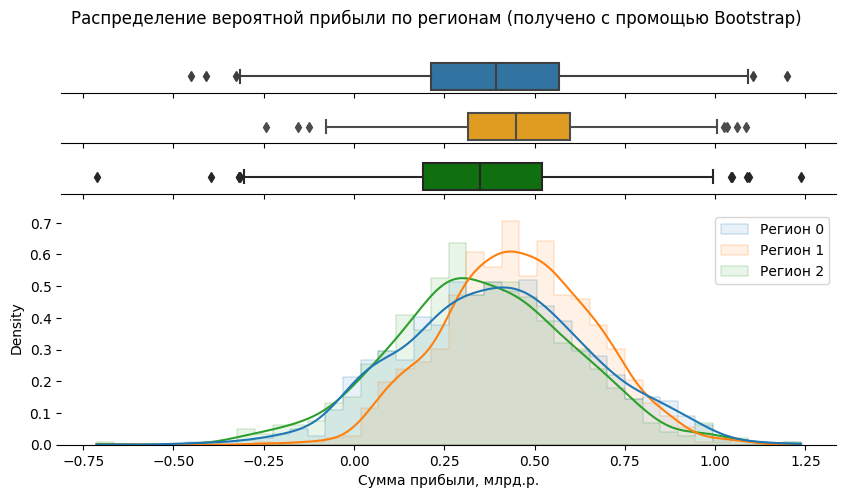

In [24]:
f,ax = plt.subplots(4, sharex=True, gridspec_kw={"height_ratios": (.1, .1, .1, .7)}, figsize=(10,5))
f.suptitle('Распределение вероятной прибыли по регионам (получено с промощью Bootstrap)')

sns.boxplot(x=profit_result['Регион 0'], ax=ax[0]).set(xlabel=None)
sns.boxplot(x=profit_result['Регион 1'], ax=ax[1], color='orange').set(xlabel=None)
sns.boxplot(x=profit_result['Регион 2'], ax=ax[2], color='green').set(xlabel=None)
sns.histplot(pd.DataFrame(profit_result), bins=40, kde=True, 
             element='step', stat='density', alpha=0.1, linewidth=0.2)

ax[0].set(yticks=[]); ax[1].set(yticks=[]); ax[2].set(yticks=[])
sns.despine(left=True); plt.xlabel('Сумма прибыли, млрд.р.'); plt.show()

In [25]:
# средняя прибыль, 95%-й доверительный интервал и риск убытков
print('регион | нижний порог довер-ого интервала | средняя прибыль (млрд.р.) | верхний порог дов.интервала | риск убытков  ')
for n, i in enumerate(profit_result):
    print(f"{n:^7}|{profit_result[i].quantile(0.025):20.3f}{' '*14}|{profit_result[i].mean():^27.3f}|\
            {profit_result[i].quantile(0.975):^17.3f}|{(profit_result[i]<0).sum()/len(profit_result[i]):9.1%}")

регион | нижний порог довер-ого интервала | средняя прибыль (млрд.р.) | верхний порог дов.интервала | риск убытков  
   0   |              -0.069              |           0.394           |                  0.915      |     6.1%
   1   |               0.061              |           0.455           |                  0.856      |     0.7%
   2   |              -0.163              |           0.354           |                  0.848      |     7.6%


## Вывод

* регион data_1 рекомендуется для разработки скважин;
* расчёт произведён с помощью машинного обучения линейной модели и техники Bootstrap (1000 выборок по 500 разведочных скважин и по 200 скважин в разработке); 
* риск убытков по трём регионам соответственно: 6.1%, 0.7%, 7.6%;
* средняя прибыль в доверительном Bootstrap-интервале по регионам 0, 1, 2 соответсвенно, млрд.р.: 0.394, 0.455, 0.354.

Таким образом без физического бурения, только с помощью исторических данных и ML возможно сделать вывод, в каком регионе лучше будет предсказан объём скважин. Как следствие, просчитать экономическую целесообразность и сделать предпочтение по региону.

Важная аномалия в исходных данных.\
В data_1 видим предельно высокую корреляцию между признаком f2 и объёмом запасов в скважине.\
Либо это утечка целевого признака, либо особенность региона.\
Из-за данной высокой корреляции качество предсказаний модели в регионе "1" высокое.\
В реальном производстве необходимо выяснить с коллегами причину такой высокой связи.